In [1]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, HBox, HTML, FloatText
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=18)
import numpy as np
import warnings


from hyperfet.devices import SCMOSFET,VO2,HyperFET
import hyperfet.approximations as appr
import hyperfet.extractions as extr
from hyperfet.references import si

In [2]:
vo2_params={
    "rho_m":si("5e-4 ohm cm"),
    "rho_i":si("80 ohm cm"),
    "J_MIT":si("2e6 A/cm^2"),
    "J_IMT":si(".55e4 A/cm^2"),
    "V_met":0,
    "L":si("8nm"),
    "W":si("14nm"),
    "T":si("14nm")
}
vo2=VO2(**vo2_params)

VDD=.5

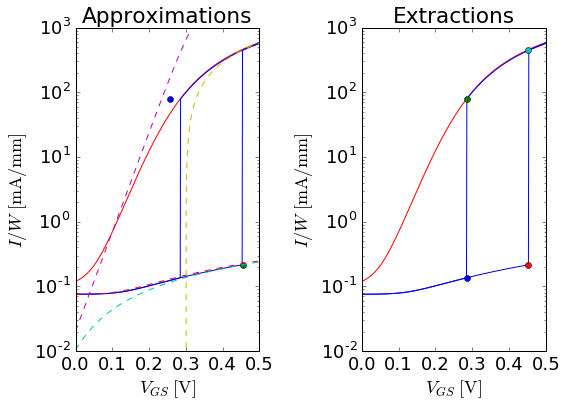

In [3]:
fet=None
out=HTML()
@interact(VT0=FloatSlider(value=.35,min=0,max=1,step=.05,continuous_update=False,
                          description=r'$V_\mathrm{T0}$'),
          W=FloatSlider(value=50,min=10,max=100,step=10,continuous_update=False,
                        description=r'$W \mathrm{[nm]}$'),
          Cinv_vxo=FloatSlider(value=3000,min=1000,max=5000,step=400,continuous_update=False,
                               description=r'$C_\mathrm{inv}v_{x_o}$'),
          SS=FloatSlider(value=.065,min=.05,max=.09,step=.005,continuous_update=False,
                         description=r'$SS$'),
          alpha=FloatSlider(value=2.5,min=0,max=5,step=.5,continuous_update=False,
                            description=r'$\alpha$'),
          beta=FloatSlider(value=1.8,min=0,max=4,step=.1,continuous_update=False,
                           description=r'$\beta$'),
          VDD=FloatSlider(value=.5,min=.3,max=1,step=.05,continuous_update=False,
                          description=r'$V_\mathrm{DD}$'),
          VDsats=FloatSlider(value=.1,min=.1,max=2,step=.1,continuous_update=False,
                             description=r'$V_\mathrm{DSATS}$'),
          delta=FloatSlider(value=.1,min=0,max=.5,step=.1,continuous_update=False,
                            description=r'$\delta$'),
          log10Gleak=FloatSlider(value=-8,min=-14,max=-5,step=1,continuous_update=False,
                                 description=r'$\log G_\mathrm{leak}$')
         )
def show_hf(VT0,W,Cinv_vxo,SS,alpha,beta,VDsats,VDD,delta,log10Gleak):
    global fet
    plt.figure(figsize=(12,6))
    fet=SCMOSFET(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    
    #shift=approx_shift(HyperFET(fet,vo2),VDD)    
    VD=np.array(VDD)
    VG=np.linspace(0,VDD,500)

    ### PLOT 1
    plt.subplot(131)
    I=fet.ID(VD=VD,VG=VG)
    plt.plot(VG,I/fet.W,'r')
    
    hf=HyperFET(fet,vo2)
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,'b')
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,'b')
    
    apprVleft,apprVright=appr.Vleft(hf,VD),appr.Vright(hf,VD)
    plt.plot(apprVleft,vo2.I_MIT/fet.W,'o')
    plt.plot(apprVright,vo2.I_IMT/fet.W,'o')
    
    
    plt.plot(VG,appr.lowerbranch(hf,VD,VG)/fet.W,'--')
    plt.plot(VG,appr.lowernoleak(hf,VD,VG)/fet.W,'--')
    plt.plot(VG,appr.upperbranchsubthresh(hf,VD,VG)/fet.W,'--')
    plt.plot(VG,appr.upperbranchinversion(hf,VD,VG)/fet.W,'--')    

    plt.yscale('log')
    plt.ylim(1e-2,1e3)
    plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
    plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
    plt.title('Approximations')
    
    ### PLOT 2
    plt.subplot(132)
    I=fet.ID(VD=VD,VG=VG)
    plt.plot(VG,I/fet.W,'r')
    
    hf=HyperFET(fet,vo2)
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,'b')
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,'b')
    
    Vl,Ill,Ilu=extr.left(VG,If,Ib)
    Vr,Irl,Iru=extr.right(VG,If,Ib)
    plt.plot(Vl,Ill/fet.W,'o')
    plt.plot(Vl,Ilu/fet.W,'o')
    plt.plot(Vr,Irl/fet.W,'o')
    plt.plot(Vr,Iru/fet.W,'o')
    

    plt.yscale('log')
    plt.ylim(1e-2,1e3)
    plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
    plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
    plt.title('Extractions')

    plt.tight_layout()
    
    out.value=r"<strong>Approx Vleft</strong> {:.2g}, <strong>Approx Vright</strong> {:.2g}".format(apprVleft,apprVright)
display(out)
#display(HBox([Latex("Approx Vleft: "),box_apprVleft,Latex("Approx Vright "),box_apprVright]))